# Part 2.4: Optimal Policies and Bellman Optimality

Welcome to Part 2.4! So far, we've learned how to **evaluate** policies using the Bellman expectation equations. Now we're going to learn how to find the **best** policy - the optimal policy that maximizes expected return.

## What This Notebook Covers
- Optimal value functions: V*(s) and Q*(s,a)
- Bellman optimality equations
- Finding optimal policies from Q*
- Value iteration (preview of Part 3)
- Comparing optimal vs. random policies

## What This Notebook Does NOT Cover

| Topic | Why Not Here | Where to Find It |
|-------|--------------|------------------|
| **Iterative algorithms for solving MDPs** | We use value iteration as a preview, but don't cover the theory | Part 3 covers policy evaluation, policy iteration, and value iteration in depth |
| **Model-free methods** | We assume we know the MDP model (transitions and rewards) | Parts 4-5 cover Q-learning, SARSA, and learning without knowing the model |

## Prerequisites
- Completed 02_1 (Markov chains), 02_2 (MRPs), and 02_3 (MDPs)
- Understanding of the Bellman expectation equations
- Understanding of optimization (maximization)

## How to Read This Notebook
1. **Understand the concept of optimality** - What does "best" mean in RL?
2. **See the power of the max operator** - How max replaces policy averaging
3. **Appreciate the non-linearity** - Why we can't use matrix inversion for Bellman optimality

Let's find the optimal policy!


---
## Setup

First, let's import the necessary libraries and set up our environment.

> **Note:** If you're running this in a fresh environment, uncomment and run the installation cell below first.

In [1]:
# Install necessary libraries (uncomment if needed)
# !pip install gymnasium[toy-text] numpy matplotlib seaborn

In [2]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set style for plots
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

# Set random seed for reproducibility
np.random.seed(42)

print("Setup complete!")

Setup complete!


In [3]:
# Helper functions from previous notebooks

def extract_mdp_components(env):
    """Extract P and R from a Gymnasium environment."""
    n_states = env.observation_space.n
    n_actions = env.action_space.n
    
    T = np.zeros((n_states, n_actions, n_states))
    R = np.zeros((n_states, n_actions))
    
    for s in range(n_states):
        for a in range(n_actions):
            for prob, next_s, reward, done in env.unwrapped.P[s][a]:
                T[s, a, next_s] += prob
                R[s, a] += prob * reward
    
    return T, R

def mdp_to_mrp(T, R_sa, policy):
    """Convert MDP with policy to MRP."""
    n_states = T.shape[0]
    n_actions = T.shape[1]
    
    P_mrp = np.zeros((n_states, n_states))
    for s in range(n_states):
        for a in range(n_actions):
            P_mrp[s] += policy[s, a] * T[s, a]
    
    R_mrp = np.sum(policy * R_sa, axis=1)
    return P_mrp, R_mrp

def compute_V_pi(T, R_sa, policy, gamma):
    """Compute V^π using direct solution of Bellman equation."""
    P_mrp, R_mrp = mdp_to_mrp(T, R_sa, policy)
    n_states = len(R_mrp)
    I = np.eye(n_states)
    V = np.linalg.solve(I - gamma * P_mrp, R_mrp)
    return V

def compute_Q_from_V(T, R_sa, V, gamma):
    """Compute Q^π from V^π."""
    n_states, n_actions = R_sa.shape
    Q = np.zeros((n_states, n_actions))
    
    for s in range(n_states):
        for a in range(n_actions):
            Q[s, a] = R_sa[s, a] + gamma * np.sum(T[s, a] * V)
    
    return Q

def visualize_q_values(Q, env, title="Q-Values"):
    """Visualize Q-values showing best action in each state."""
    desc = env.unwrapped.desc.astype(str)
    nrow, ncol = desc.shape
    colors = {'S': 'lightblue', 'F': 'white', 'H': 'lightcoral', 'G': 'lightgreen'}
    
    fig, ax = plt.subplots(figsize=(10, 10))
    
    for i in range(nrow):
        for j in range(ncol):
            state = i * ncol + j
            cell = desc[i, j]
            
            rect = plt.Rectangle((j, nrow-1-i), 1, 1, fill=True,
                                 facecolor=colors.get(cell, 'white'), edgecolor='black')
            ax.add_patch(rect)
            
            ax.text(j + 0.5, nrow - 1 - i + 0.5, cell, ha='center', va='center',
                   fontsize=14, fontweight='bold', alpha=0.3)
            
            if cell not in ['H', 'G']:
                best_action = np.argmax(Q[state])
                positions = [(0.2, 0.5), (0.5, 0.2), (0.8, 0.5), (0.5, 0.8)]  # L, D, R, U
                for a in range(4):
                    x, y = positions[a]
                    color = 'green' if a == best_action else 'black'
                    weight = 'bold' if a == best_action else 'normal'
                    ax.text(j + x, nrow - 1 - i + y, f'{Q[state, a]:.2f}',
                           ha='center', va='center', fontsize=7, 
                           color=color, fontweight=weight)
    
    ax.set_xlim(0, ncol)
    ax.set_ylim(0, nrow)
    ax.set_aspect('equal')
    ax.axis('off')
    ax.set_title(f"{title}\n(Green = best action, positions: ←left, ↓bottom, →right, ↑top)", fontsize=12)
    
    plt.tight_layout()
    return fig, ax

print("Helper functions loaded!")

Helper functions loaded!


In [4]:
# Set up the FrozenLake environment
env = gym.make("FrozenLake-v1", render_mode="rgb_array", is_slippery=True)
env.reset(seed=42)

T_mdp, R_mdp = extract_mdp_components(env)
n_states = env.observation_space.n
n_actions = env.action_space.n
action_names = {0: 'LEFT', 1: 'DOWN', 2: 'RIGHT', 3: 'UP'}
gamma = 0.99

# Create random policy for comparison
pi_random = np.ones((n_states, n_actions)) / n_actions
V_random = compute_V_pi(T_mdp, R_mdp, pi_random, gamma)
Q_random = compute_Q_from_V(T_mdp, R_mdp, V_random, gamma)

print("Environment ready!")
print(f"States: {n_states}, Actions: {n_actions}, γ: {gamma}")

Environment ready!
States: 16, Actions: 4, γ: 0.99


---
# 1. Optimal Value Functions and Bellman Optimality

**Revisiting Optimal Value Functions: From Concepts to Mathematics**

In **Notebook 01_3**, you learned about optimal value functions V* and Q* from a conceptual perspective:
- V*(s) and Q*(s,a) represent the best possible values
- The optimal policy π*(s) = argmax_a Q*(s,a)
- The distinction between Q^π (policy-specific) and Q* (optimal)

**Why are we revisiting this topic now?**

In 01_3, we introduced these concepts intuitively to help you understand the *goal* of reinforcement learning. Now that you've learned the **MDP framework** (in 02_1-02_3), we can be more precise:

**What's new in this notebook:**
1. **Bellman Optimality Equations** - the mathematical foundation for finding V* and Q*
2. **The max operator** - why optimization is different from evaluation
3. **Non-linearity** - why we need iterative algorithms (preview of Part 3)
4. **Practical computation** - using value iteration to actually find optimal policies

Think of it this way:
- **01_3**: "Here's what optimal means and why it matters" (the destination)
- **02_4**: "Here's how the math works to get there" (the roadmap)

Now let's see how the MDP framework gives us the tools to find optimal policies!

---

So far, we've evaluated specific policies. Now let's find the **best** policy!

## Optimal Value Functions

The **optimal state-value function** $V^*(s)$ is the maximum value achievable:

$$V^*(s) = \max_\pi V^\pi(s)$$

**Plain English:** "The optimal state-value for state s equals the maximum over all policies of the state-value under that policy."

**Formula components:**
- $V^*(s)$ = the optimal state-value function for state $s$ (the asterisk * means "optimal")
- $\max_\pi$ = the maximum over all possible policies $\pi$
- $V^\pi(s)$ = the state-value function for state $s$ under policy $\pi$

The **optimal action-value function** $Q^*(s, a)$ is the maximum action-value:

$$Q^*(s, a) = \max_\pi Q^\pi(s, a)$$

**Plain English:** "The optimal action-value for state s and action a equals the maximum over all policies of the action-value under that policy."

**Formula components:**
- $Q^*(s, a)$ = the optimal action-value function for state $s$ and action $a$ (the asterisk * means "optimal")
- $\max_\pi$ = the maximum over all possible policies $\pi$
- $Q^\pi(s, a)$ = the action-value function for state $s$ and action $a$ under policy $\pi$

## Key Theorem

For any finite MDP:
1. There exists an **optimal policy** $\pi^*$ that is better than or equal to all other policies
2. All optimal policies achieve the same $V^*$ and $Q^*$
3. There always exists a **deterministic** optimal policy

## Finding Optimal Policy from $Q^*$

If we know $Q^*$, the optimal policy is simple:

$$\pi^*(s) = \arg\max_a Q^*(s, a)$$

**Plain English:** "The optimal policy for state s equals the action that maximizes the optimal action-value for state s."

**Formula components:**
- $\pi^*(s)$ = the optimal policy for state $s$
- $\arg\max_a$ = "the argument (action) that maximizes" (finds which action $a$ gives the highest value)
- $Q^*(s, a)$ = the optimal action-value function for state $s$ and action $a$

**Just pick the action with the highest Q-value!**

## Bellman Optimality Equations

The optimal value functions satisfy special Bellman equations:

### For $V^*$:

$$V^*(s) = \max_a \left[ R^a_s + \gamma \sum_{s'} P^a_{ss'} V^*(s') \right]$$

**Plain English:** "The optimal state-value for state s equals the maximum over all actions of the quantity in brackets, where the brackets contain the reward plus gamma times the sum over next states of the transition probability times the optimal next state value."

**Formula components:**
- $V^*(s)$ = the optimal state-value function for state $s$
- $\max_a$ = the maximum over all possible actions $a$
- $[\cdot]$ = the brackets group what we're maximizing over
- $R^a_s$ = the expected reward for state $s$ when taking action $a$
- $\gamma$ = gamma, the discount factor
- $\sum_{s'}$ = the sum over all possible next states $s'$
- $P^a_{ss'}$ = the transition probability from state $s$ to state $s'$ when taking action $a$
- $V^*(s')$ = the optimal state-value function for the next state $s'$

### For $Q^*$:

$$Q^*(s, a) = R^a_s + \gamma \sum_{s'} P^a_{ss'} \max_{a'} Q^*(s', a')$$

**Plain English:** "The optimal action-value for state s and action a equals the reward plus gamma times the sum over next states of the transition probability times the maximum over next actions of the optimal action-value."

**Formula components:**
- $Q^*(s, a)$ = the optimal action-value function for state $s$ and action $a$
- $R^a_s$ = the expected reward for state $s$ when taking action $a$
- $\gamma$ = gamma, the discount factor
- $\sum_{s'}$ = the sum over all possible next states $s'$
- $P^a_{ss'}$ = the transition probability from state $s$ to state $s'$ when taking action $a$
- $\max_{a'}$ = the maximum over all possible next actions $a'$ (in the next state)
- $Q^*(s', a')$ = the optimal action-value function for the next state $s'$ and next action $a'$

### Key Difference from Bellman Expectation Equations

| Aspect | Expectation Equations | Optimality Equations |
|--------|----------------------|---------------------|
| **Operator** | Policy-weighted sum over actions | Maximum over actions |
| **Formula** | Σ π(a\|s) [...] | max [...] |
| **Linearity** | Linear in V | Non-linear (due to max) |
| **Solution method** | Matrix inversion | Iterative algorithms |

**Why this matters:**
- **Expectation**: Averages over actions according to policy π → linear system → direct solution
- **Optimality**: Chooses best action → non-linear → requires iterative methods (Part 3)

In [5]:
# Value Iteration to find V* (preview of notebook 03)
def value_iteration(T, R, gamma, theta=1e-8, max_iterations=1000):
    """Find optimal value function using Value Iteration."""
    n_states = T.shape[0]
    n_actions = T.shape[1]
    
    V = np.zeros(n_states)
    
    for iteration in range(max_iterations):
        V_new = np.zeros(n_states)
        
        for s in range(n_states):
            # V*(s) = max_a [R(s,a) + γ × Σ P(s'|s,a) × V*(s')]
            q_values = np.zeros(n_actions)
            for a in range(n_actions):
                q_values[a] = R[s, a] + gamma * np.sum(T[s, a] * V)
            V_new[s] = np.max(q_values)
        
        # Check convergence
        if np.max(np.abs(V_new - V)) < theta:
            print(f"Value Iteration converged after {iteration + 1} iterations")
            break
        
        V = V_new
    
    return V

# Find optimal value function
V_star = value_iteration(T_mdp, R_mdp, gamma=0.99)

# Compute Q* from V*
Q_star = compute_Q_from_V(T_mdp, R_mdp, V_star, gamma=0.99)

# Extract optimal policy
pi_star = np.zeros((n_states, n_actions))
for s in range(n_states):
    best_action = np.argmax(Q_star[s])
    pi_star[s, best_action] = 1.0

print("\nOptimal Value Function V*:")
print(V_star.reshape(4, 4).round(4))

Value Iteration converged after 438 iterations

Optimal Value Function V*:
[[0.542  0.4988 0.4707 0.4569]
 [0.5585 0.     0.3583 0.    ]
 [0.5918 0.6431 0.6152 0.    ]
 [0.     0.7417 0.8628 0.    ]]


---

## Computing Optimal Values: A Preview

**What we've learned so far:**
- We know the *definition* of V* and Q*: the best possible values
- We have the *Bellman optimality equations*: recursive relationships that V* and Q* must satisfy

**What we haven't learned yet:**
- How to actually *compute* V* and Q* from these equations

**The challenge:**

Remember the Bellman optimality equation:
$$V^*(s) = \max_a \left[ R^a_s + \gamma \sum_{s'} P^a_{ss'} V^*(s') \right]$$

This is a **system of non-linear equations** (one equation for each state). Unlike the Bellman expectation equations, we can't just invert a matrix to solve it. The `max` operator makes it non-linear.

**The solution: Iterative algorithms**

To find V*, we need iterative algorithms like:
- **Value Iteration** (what we'll use below as a preview)
- **Policy Iteration** (another approach)
- **Linear Programming** (yet another approach)

These algorithms repeatedly apply the Bellman optimality equation until the values converge to V*.

**What we're about to do:**

In the code cell below, we'll use **Value Iteration** to compute V* for FrozenLake. This gives us:
1. The optimal value function V*(s) for every state
2. The optimal Q-function Q*(s,a) for every state-action pair  
3. The optimal policy π*(s) derived from Q*

**Important: Don't worry if you don't fully understand the algorithm yet!**

The goal here is NOT to learn value iteration in detail - that comes in **Part 3 (Dynamic Programming)**. 

**The goal here is to:**
- See that V* and Q* are computable (not just theoretical concepts)
- Visualize what the optimal values and policy look like for FrozenLake
- Compare optimal vs random policy performance
- Appreciate that we need iterative methods (not matrix inversion)

Think of this as seeing the "magic trick" before learning how the magician does it. In Part 3, we'll learn the algorithm step-by-step. For now, just focus on the *results* and what they tell us about optimal policies.

**For the curious:**

The basic idea of value iteration is simple:
1. Start with V(s) = 0 for all states
2. Repeatedly apply: V_new(s) = max_a [R(s,a) + γ Σ P(s'|s,a) V(s')]
3. Stop when V stops changing (converges to V*)

That's it! The algorithm guarantees convergence to the optimal values. We'll explore *why* it works in Part 3.

**Question these plots answer:** 'What is the optimal value and policy for FrozenLake?'



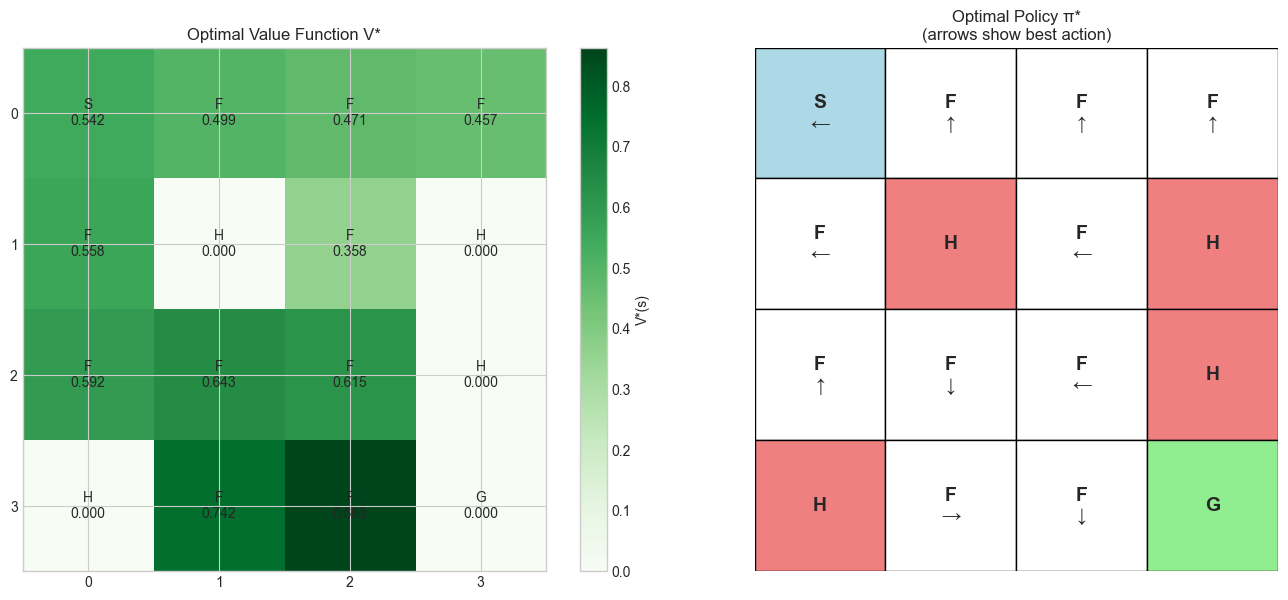

In [6]:
# Visualize optimal values and policy
print("**Question these plots answer:** 'What is the optimal value and policy for FrozenLake?'\n")

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot V*
desc = env.unwrapped.desc.astype(str)
nrow, ncol = desc.shape
V_grid = V_star.reshape(nrow, ncol)

im = axes[0].imshow(V_grid, cmap='Greens', vmin=0, vmax=V_star.max())
plt.colorbar(im, ax=axes[0], label='V*(s)')

for i in range(nrow):
    for j in range(ncol):
        state = i * ncol + j
        axes[0].text(j, i, f'{desc[i,j]}\n{V_star[state]:.3f}', 
                    ha='center', va='center', fontsize=10)

axes[0].set_title('Optimal Value Function V*', fontsize=12)
axes[0].set_xticks(range(ncol))
axes[0].set_yticks(range(nrow))

# Plot optimal policy
action_arrows = ['←', '↓', '→', '↑']
colors = {'S': 'lightblue', 'F': 'white', 'H': 'lightcoral', 'G': 'lightgreen'}

for i in range(nrow):
    for j in range(ncol):
        state = i * ncol + j
        cell = desc[i, j]
        
        rect = plt.Rectangle((j, nrow-1-i), 1, 1, fill=True,
                             facecolor=colors.get(cell, 'white'), edgecolor='black')
        axes[1].add_patch(rect)
        
        best_action = np.argmax(Q_star[state])
        if cell not in ['H', 'G']:
            axes[1].text(j + 0.5, nrow - 1 - i + 0.5, 
                        f'{cell}\n{action_arrows[best_action]}',
                        ha='center', va='center', fontsize=14, fontweight='bold')
        else:
            axes[1].text(j + 0.5, nrow - 1 - i + 0.5, cell,
                        ha='center', va='center', fontsize=14, fontweight='bold')

axes[1].set_xlim(0, ncol)
axes[1].set_ylim(0, nrow)
axes[1].set_aspect('equal')
axes[1].axis('off')
axes[1].set_title('Optimal Policy π*\n(arrows show best action)', fontsize=12)

plt.tight_layout()
plt.show()

In [7]:
# Compare random policy vs optimal policy performance
print("**Question this comparison answers:** 'How much better is the optimal policy?'\n")

def evaluate_policy(env, policy, n_episodes=10000):
    """Evaluate a policy by running episodes."""
    total_rewards = []
    
    for _ in range(n_episodes):
        obs, _ = env.reset()
        episode_reward = 0
        done = False
        
        while not done:
            action = np.random.choice(env.action_space.n, p=policy[obs])
            obs, reward, terminated, truncated, _ = env.step(action)
            episode_reward += reward
            done = terminated or truncated
        
        total_rewards.append(episode_reward)
    
    return total_rewards

# Evaluate both policies
env = gym.make("FrozenLake-v1", is_slippery=True)

print("Policy Comparison (10,000 episodes each)")
print("=" * 50)

rewards_random = evaluate_policy(env, pi_random, n_episodes=10000)
rewards_optimal = evaluate_policy(env, pi_star, n_episodes=10000)

print(f"\nRandom Policy:")
print(f"  Success rate: {np.mean(rewards_random)*100:.2f}%")

print(f"\nOptimal Policy:")
print(f"  Success rate: {np.mean(rewards_optimal)*100:.2f}%")

improvement = (np.mean(rewards_optimal) - np.mean(rewards_random)) / np.mean(rewards_random) * 100
print(f"\nImprovement: {improvement:.1f}% relative increase")

env.close()

**Question this comparison answers:** 'How much better is the optimal policy?'

Policy Comparison (10,000 episodes each)

Random Policy:
  Success rate: 1.52%

Optimal Policy:
  Success rate: 74.33%

Improvement: 4790.1% relative increase


### How to Read These Plots

**Understanding the visualization:**

**Left Plot - Optimal Value Function V*(s):**
- **Color intensity**: Darker green = higher optimal value
- **Numbers**: The V*(s) value for each state (expected total discounted reward when acting optimally)
- **Grid positions**: Same as the FrozenLake grid (S=Start, F=Frozen, H=Hole, G=Goal)

**Right Plot - Optimal Policy π*(s):**
- **Arrows**: Show the best action to take in each state
  - ← = LEFT, ↓ = DOWN, → = RIGHT, ↑ = UP
- **No arrows**: Terminal states (Holes and Goal) have no actions

**Answering the question: "What is the optimal value and policy for FrozenLake?"**

Let's trace through a specific example to see how to read these plots:

**Example: State 10 (bottom row, third column)**

From the **left plot (V*)**:
- V*(10) = 0.615
- This means: "If I start in state 10 and act optimally, I expect to get ~0.615 total discounted reward"
- Notice state 10 has higher value than state 6 (0.358) - it's closer to the goal!

From the **right plot (π*)**:
- The arrow points → (RIGHT)
- This means: "The optimal action in state 10 is to go RIGHT"
- Why? Because going RIGHT leads toward state 14, which is very close to the goal (V*(14) = 0.863)

**Reading the optimal path from Start to Goal:**

Follow the arrows from state 0 (Start):
1. State 0 (S): → RIGHT → State 1
2. State 1 (F): ↓ DOWN → State 5 (H - Hole!)

Wait, that hits a hole! Why is this optimal?

**Key insight**: Due to the slippery ice, even the "optimal" policy can't guarantee success. The arrows show the *best action* in each state, but:
- With probability 1/3, you go in the intended direction
- With probability 2/3, you slip perpendicular

The optimal policy maximizes your *expected* return (probability-weighted average), not guarantees success. That's why even π* only achieves ~74% success rate (as we'll see in the comparison below).

**Why values decrease with distance from goal:**
- State 14 (next to goal): V*(14) = 0.863 (very high - one good move away!)
- State 10 (middle): V*(10) = 0.615 (medium - several moves needed)
- State 0 (start): V*(0) = 0.542 (lower - far from goal, many risky moves)

The values encode both:
1. **Distance to goal** (fewer steps = higher value)
2. **Risk along the way** (more holes nearby = lower value)

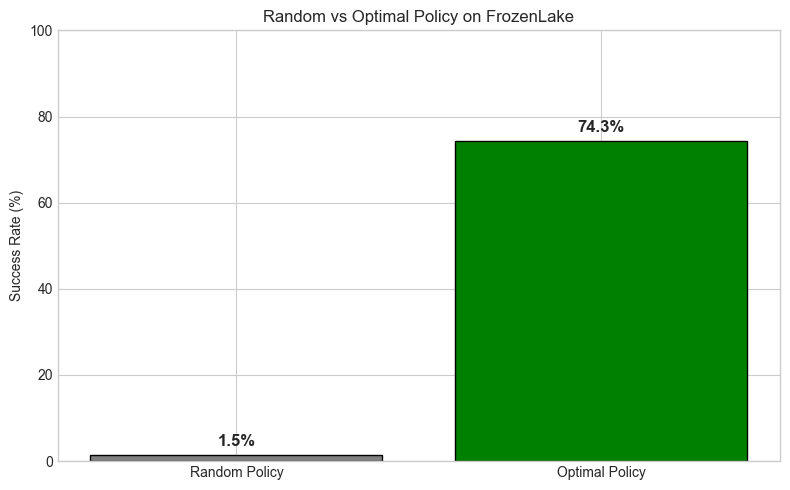

In [8]:
# Visualize the comparison
fig, ax = plt.subplots(figsize=(8, 5))

policies = ['Random Policy', 'Optimal Policy']
success_rates = [np.mean(rewards_random) * 100, np.mean(rewards_optimal) * 100]
colors = ['gray', 'green']

bars = ax.bar(policies, success_rates, color=colors, edgecolor='black')

ax.set_ylabel('Success Rate (%)')
ax.set_title('Random vs Optimal Policy on FrozenLake')
ax.set_ylim(0, 100)

for bar, rate in zip(bars, success_rates):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2,
            f'{rate:.1f}%', ha='center', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

> **Checkpoint — You should now understand:**
> - $V^*(s) = \max_\pi V^\pi(s)$ and $Q^*(s,a) = \max_\pi Q^\pi(s,a)$
> - The optimal policy is $\pi^*(s) = \arg\max_a Q^*(s,a)$
> - Bellman Optimality Equations use **max** instead of policy-weighted average
> - This non-linearity requires iterative solution methods

---
# 2. Summary and Concept Map

In this notebook, we learned how to find the best policy:

## Key Concepts

- **V*(s)**: Maximum achievable value in state s
- **Q*(s,a)**: Maximum achievable value for action a in state s
- **π*(s)**: Optimal policy - picks argmax_a Q*(s,a)
- **Bellman Optimality**: Uses max instead of policy averaging
- **Non-linearity**: max operator prevents matrix inversion
- **Optimal ≠ Perfect**: Best expected value, not guaranteed success


```
BELLMAN EQUATIONS: EXPECTATION VS OPTIMALITY
=============================================

BELLMAN EXPECTATION (Part 02_3)
   V^π(s) = Σ_a π(a|s) × [R^a_s + γ Σ_{s'} P^a_{ss'} V^π(s')]
            └─────────┘
          policy average
   
   - Evaluates a GIVEN policy π
   - Linear in V^π
   - Solvable by matrix inversion

           ↓
    Replace Σπ with max
           ↓

BELLMAN OPTIMALITY (Part 02_4)
   V*(s) = max_a [R^a_s + γ Σ_{s'} P^a_{ss'} V*(s')]
           └───┘
          choose best
   
   - Finds the BEST policy
   - Non-linear in V*
   - Requires iterative methods


FROM VALUES TO POLICY
=====================

Given Q*(s,a):
   π*(s) = argmax_a Q*(s,a)
   
Just pick the action with highest Q* value!


THE COMPLETE PICTURE
====================

02_1: Markov Chains
      (S, P)
      ↓
02_2: + Rewards → MRP
      (S, P, R, γ)
      ↓
02_3: + Actions → MDP
      (S, A, P, R, γ)
      + Policy π → Bellman Expectation
      ↓
02_4: + Optimization → Find π*
      Bellman Optimality
      ↓
Part 3: ALGORITHMS to compute π*
      - Policy Iteration
      - Value Iteration
      - Dynamic Programming
```

## What's Coming Next

In **Part 3 (Dynamic Programming)**, we'll learn the algorithms to solve MDPs:

| Algorithm | What it does | Requires |
|-----------|--------------|----------|
| **Policy Evaluation** | Compute $V^\pi$ for given policy | MDP model |
| **Policy Iteration** | Find $\pi^*$ by alternating evaluation & improvement | MDP model |
| **Value Iteration** | Find $V^*$ directly using Bellman optimality | MDP model |

These are the foundational algorithms that all of RL builds upon!


---
# 3. Your Turn

## Exercise 1: Why No Matrix Inversion?

**Question:** Why can't we use matrix inversion to solve the Bellman optimality equations, even though we used it for the Bellman expectation equations?

<details>
<summary>Click to see hint</summary>

Think about the difference between $\sum_a \pi(a|s)$ and $\max_a$. Which one is a linear operation?

</details>

<details>
<summary>Click to see answer</summary>

**The $\max$ operator makes the equations non-linear.**

**Bellman Expectation (solvable by matrix inversion):**
$$V^\pi(s) = \sum_a \pi(a|s) \left[ R^a_s + \gamma \sum_{s'} P^a_{ss'} V^\pi(s') \right]$$

This can be rewritten as:
$$V^\pi = R^\pi + \gamma P^\pi V^\pi$$
$$V^\pi = (I - \gamma P^\pi)^{-1} R^\pi$$

This works because $\sum_a \pi(a|s)$ is a **linear** weighted average.

**Bellman Optimality (NOT solvable by matrix inversion):**
$$V^*(s) = \max_a \left[ R^a_s + \gamma \sum_{s'} P^a_{ss'} V^*(s') \right]$$

The $\max$ operator is **non-linear**:
- $\max(x_1 + x_2, y_1 + y_2) \neq \max(x_1, y_1) + \max(x_2, y_2)$
- Cannot be expressed as matrix multiplication
- No closed-form solution

**Solution:** Use iterative methods like value iteration or policy iteration (Part 3).

</details>

## Exercise 2: Verify Optimal Policy

**Task:** Pick a specific state (e.g., state 6) and verify that $\pi^*(6) = \arg\max_a Q^*(6,a)$.

1. Look at the $Q^*$ values for all 4 actions in state 6
2. Identify which action has the highest $Q^*$ value
3. Verify that the optimal policy indeed selects this action

**Bonus question:** Why might the optimal action in state 6 differ from the optimal action in state 10, even though both are frozen tiles?


In [9]:
# YOUR CODE HERE
# Verify that π*(s) = argmax_a Q*(s,a) for state 6

# state = 6
# print(f"Verifying Optimal Policy for State {state}")
# print("=" * 50)

# print(f"\nQ* values for state {state}:")
# for a in range(4):
#     print(f"  Action {a} ({action_names[a]}): Q*({state},{a}) = {Q_star[state, a]:.4f}")

# best_action = np.argmax(Q_star[state])
# print(f"\nBest action: {best_action} ({action_names[best_action]})")

# policy_action = np.argmax(pi_star[state])
# print(f"Policy π* selects: {policy_action} ({action_names[policy_action]})")

# print(f"\nMatch: {best_action == policy_action}")

---

**Congratulations! You've completed Part 2.4 of the RL Tutorial!**

Key takeaways:
- The optimal value functions V*(s) and Q*(s,a) represent the maximum achievable value
- Bellman optimality equations use **max** instead of policy-weighted averaging
- The optimal policy π*(s) = argmax_a Q*(s,a) simply picks the best action
- The max operator makes Bellman optimality equations non-linear, requiring iterative methods
- Even the optimal policy cannot achieve 100% success in stochastic environments

**What's Next:**

In **Part 3 (Dynamic Programming)**, we'll learn the algorithms to solve MDPs:
- Policy evaluation: Computing V^π for any policy
- Policy iteration: Alternating evaluation and improvement to find π*
- Value iteration: Computing V* directly

These are the foundational algorithms that underpin all of reinforcement learning!

Next: [03_dynamic_programming.ipynb](03_dynamic_programming.ipynb)